KNN model loaded from file.


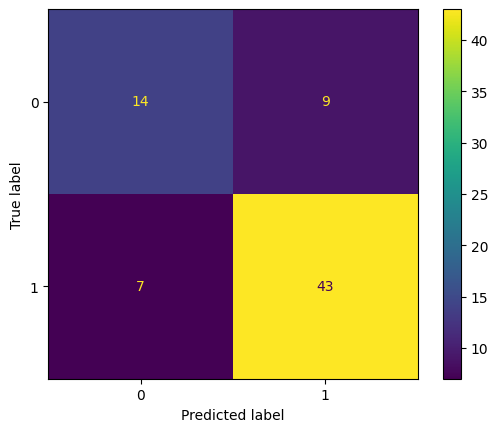


Enter weather parameters for prediction:


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import os

def get_float_input(prompt):
    
    while True:
        try:
            return float(input(prompt))
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_weather_input():
    
    print("\nEnter weather parameters for prediction:")
    return {
        'pressure': get_float_input("Atmospheric pressure (hPa): "),
        'maxtemp': get_float_input("Maximum temperature (°C): "),
        'temparature': get_float_input("Current temperature (°C): "),
        'mintemp': get_float_input("Minimum temperature (°C): "),
        'dewpoint': get_float_input("Dew point temperature (°C): "),
        'humidity': get_float_input("Humidity (%): "),
        'cloud': get_float_input("Cloud cover (%): "),
        'sunshine': get_float_input("Sunshine hours: "),
        'winddirection': get_float_input("Wind direction (degrees): "),
        'windspeed': get_float_input("Wind speed (km/h): ")
    }

df = pd.read_csv('Rainfall.csv')
df.columns = df.columns.str.strip()
df['rainfall'] = df['rainfall'].astype(str).str.lower().str.strip()
df = df[df['rainfall'].isin(['yes', 'no'])]
df['rainfall_label'] = df['rainfall'].map({'yes': 1, 'no': 0})


feature_cols = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
                'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['rainfall_label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


model_path = 'knn_model.pkl'
if os.path.exists(model_path):
    model = joblib.load(model_path)
    print("KNN model loaded from file.")
else:
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    joblib.dump(model, model_path)
    print("KNN model trained and saved.")
    
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()


user_data = pd.DataFrame([get_weather_input()])
user_scaled = scaler.transform(user_data)

pred_proba = model.predict_proba(user_scaled)[0][1]
prediction = model.predict(user_scaled)

print(f"\nRainfall Prediction: {'Yes' if prediction[0] else 'No'}")
print(f"Confidence: {pred_proba:.1%}")


print("\nModel Performance:")
print(classification_report(y_test, model.predict(X_test)))
